# Hello world

This example contains two parts: you will first create a simple quantum program and run it on a quantum system.  Because actual quantum research requires much more robust programs, in the [Scale to large numbers of qubits](#scale-to-large-numbers-of-qubits) section, you will scale the simple program up to utility level.  You can also watch this Hello World in practice in the Hello World episode of the Coding with Qiskit video series. 

In [ ]:
%%html
<iframe width="560" height="315" src="https://www.youtube.com/watch?v=93-zLTppFZw" title="Hello World" frameborder="0" allow="accelerometer; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>

## Before you begin

Follow the [Install and set up](install) instructions if you haven't already, including the steps to [Set up to use IBM Quantum&trade; Platform](setup-channel#set-up-to-use-ibm-quantum-platform).

We recommend that you use the [Jupyter](https://jupyter.org/install) development environment to interact with quantum computers. Be sure to install the recommended extra visualization support (`pip install qiskit[visualization]`), and note that zsh users need to put `'qiskit[visualization]'` in single quotes. You'll also need the `matplotlib` package for the second part of this example.


To learn about quantum computing in general, check out the [Basics of quantum information course](https://learning.quantum.ibm.com/course/basics-of-quantum-information) in IBM Quantum Learning.

The four steps to writing a quantum program using Qiskit Patterns are:

1.  Map the problem to a quantum-native format

2.  Optimize the circuits and operators

3.  Execute using a quantum primitive function

4.  Analyze the results

## Create and run a simple quantum program

### Step 1. Map the problem to a quantum-native format

In a quantum program, *quantum circuits* are the native format in which to represent quantum instructions, and *operators* represent the observables to be measured. When creating a circuit, you'll usually create a new [`QuantumCircuit`](/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit) object, then add instructions to it in sequence.

The following code cell creates a circuit that produces a *Bell state,* which is a state wherein two (or more) qubits are fully entangled with each other.

<Admonition type="note" title="Note: bit ordering">
  The Qiskit SDK uses the LSb 0 bit numbering where the $n^{th}$ digit has value $1 \ll n$ or $2^n$. Because we usually write numbers on paper with the most significant digits to the left and the least significant digits to the right (in the Hindu-Arabic system used in most of the world), this has the consequence that the bits are labeled with indices increasing <b>from right to left</b>. This LSb 0 convention makes mathematics easier and is the most commonly used for modern digital electronics, although the opposite convention MSb 0 is also found in some domains. Converting the $i^{th}$ index between LSb 0 and MSb 0 conventions on an $n$-bit register is as simple as $i \rightarrow n-i-1$. This differs across authors and software packages, so be aware! For more details, see the [Bit-ordering in the Qiskit SDK](../build/bit-ordering) topic.
</Admonition>

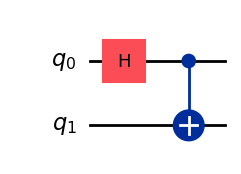

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator

# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

See [`QuantumCircuit`](/api/qiskit/qiskit.circuit.QuantumCircuit#quantumcircuit) in the documentation for all available operations.

---

While creating quantum circuits, we also must consider what type of data we want to get back after execution, and there are are two ways to do so within Qiskit. You can either obtain a probability distribution for a set of qubits you choose to measure, or obtain the expectation value of an observable. Preparing your workload to measure your circuit in one of these two ways is done through the [Qiskit primitives](../run/primitives-get-started) (explained in detail in [Step 3](#step-3-execute-using-the-quantum-primitives) of this page).

For this example, we will be measuring some expectation values using the `qiskit.quantum_info` submodule which will be specified using operators (these are mathematical objects used to represent an action or process which changes a quantum state). The following code cell creates six two-qubit Pauli operators: `IZ`, `IX`, `ZI`, `XI`, `ZZ`, and `XX`.

In [19]:
# Set up six different observables.
from qiskit.quantum_info import Pauli

ZZ = Pauli('ZZ')
ZI = Pauli('ZI')
IZ = Pauli('IZ')
XX = Pauli('XX')
XI = Pauli('XI')
IX = Pauli('IX')

observables = [IZ, IX, ZI, XI, ZZ, XX]
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

<Admonition type="note" title="Operator Notation">

Here, something like the `ZZ` operator is a shorthand for the tensor product $Z\otimes Z$ which essentially means measuring Z on qubit 0 and Z on qubit 1 together and obtaining information about the correlation between qubit 0 and qubit 1. Expectation values like this are also typically written as $\langle Z_0 Z_1 \rangle$.

If the state is entangled, then the measurement of $\langle Z_0 Z_1 \rangle$ should be equal to 1.

</Admonition>

### Step 2. Optimize the circuits and operators

When executing circuits on a device, it is an important step to optimize the set of instructions which the circuit contains and work to minimize the overall depth (roughly the number of instructions) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise. Additionally, the circuit's instructions must conform to a backend device's [Instruction Set Architecture (ISA)](../transpile/#instruction-set-architecture) and takes both the device's basis gates as well as its qubit connectivity into account.

The code snippet below will instantiate a real device to submit a job to and transform the circuit to match that backend's ISA.

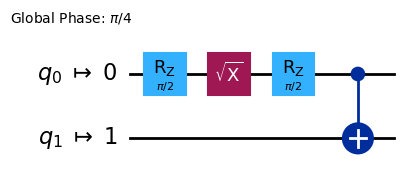

In [20]:
# If you did not previously save your credentials, use the following line instead:
# service = QiskitRuntimeService(channel="ibm_quantum", token="<MY_IBM_QUANTUM_TOKEN>")
service = QiskitRuntimeService()


# Run on the least-busy backend you have access to
backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw('mpl', idle_wires=False)

### Step 3. Execute using the quantum primitives

Quantum computers can produce random results, so you'll often want to collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable using the `Estimator` class. `Estimator` is one of two [primitives](../run/primitives-get-started); the other is `Sampler`, which can be used to get data from a quantum computer.  These objects possess a `run()` method that executes the selection of circuits, observables, and parameters (if applicable), using what's known as a [primitive unified bloc (PUB)](../run/primitives#sampler-v2).

In [21]:
# Construct the Estimator instance we want to use.
from qiskit_ibm_runtime import EstimatorV2 as Estimator

estimator = Estimator(backend=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job id in order to retrieve your job data at a later time
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: crbfya9djmqg008kd5p0


Once a job is submitted, you can wait until either the job is completed within your current python instance, or use the `job_id` in order to retrieve the data at a later time.  (See the [section on retrieving jobs](../run/monitor-job#retrieve-job-results-at-a-later-time) for more info)

Once a job is completed, we can examine its output through the job's `result()` attribute shown below.

In [ ]:
# This is the result of the entire submission.  We submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]

<Admonition type="note" title="Alternative: run the example using a simulator">

When running your quantum program on a real device your workload must wait in a queue before it is run. If you would like to save some time with this example, you can instead use the following code to run this small workload on a local simulator (using the [`fake_provider`](../api/qiskit-ibm-runtime/fake_provider)). Bear in mind this will only work for this small circuit, but when you scale up in the next section you will need to use a real device.

```python
# Use the following code instead if you want to run on a simulator:


from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
backend = FakeAlmadenV2()

estimator = Estimator(backend)


# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

job = estimator.run([(isa_circuit, mapped_observables)])
result = job.result()


# This is the result of the entire submission.  We submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had five observables,
# so contains information on all five.
pub_result = job.result()[0]
```
</Admonition>

### Step 4. Analyze the results

The analyze step is typically where you might postprocess your results using something like measurement error mitigation or zero noise extrapolation. You might feed these results into another workflow for further analysis or prepare a plot of the key values and data. In general this will be specific to your problem and so for this example,we'll simply plot each of the expectation values that were measured for our circuit.

The expectation values and standard deviations for the observables you specified are accessed through the `PubResult.data.evs` and `PubResult.data.stds` attributes of the job results. To obtain the results from the sampler, use the `PubResult.data.meas.get_counts()` function which will return a `dict` of measurements in the form of bitstrings as keys and counts as their corresponding values.

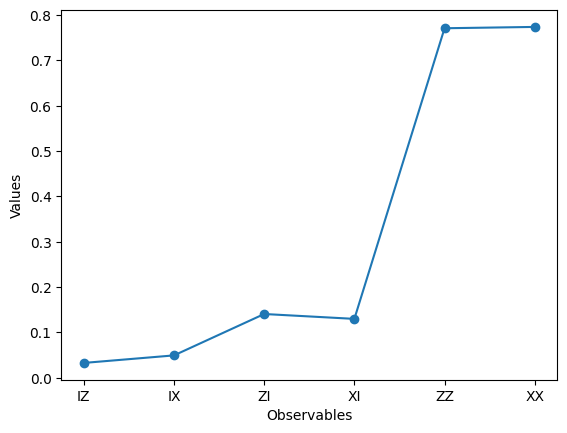

In [23]:
# Plot the result

from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
plt.plot(observables_labels, values, '-o')
plt.xlabel('Observables')
plt.ylabel('Values')
plt.show()

Here we see that for qubits 0 and 1, the independent expectation values of both X and Z are 0, while the correlations (`XX` and `ZZ`) are 1. This is a hallmark of quantum entanglement.

## Scale to large numbers of qubits

In quantum computing, utility-scale work is crucial for making progress in the field. Such work requires computations to be done on a much larger scale; working with circuits that might use over 100 qubits and over 1000 gates. This example demonstrates how you can accomplish utility-scale work on IBM Quantum systems by working with a 100-qubit Bell state.  It uses the Qiskit Patterns workflow and ends by measuring the expectation value $\langle Z_0 Z_i \rangle $ for each qubit.

### Step 1. Map the problem

Write a function that returns a `QuantumCircuit` that prepares an $n$-qubit Bell state then use that function to prepare a 100-qubit Bell state and collect the observables to be measured.

In [24]:
from qiskit import QuantumCircuit

def get_qc_for_n_qubit_Bell_state(n: int) -> QuantumCircuit:
    """This function will create a qiskit.QuantumCircuit (qc) for an n-qubit Bell state.

    Args:
        n (int): Number of qubits in the n-qubit Bell state

    Returns:
        QuantumCircuit: Quantum circuit that generate the n-qubit Bell state, assuming all qubits start in the 0 state
    """
    if isinstance(n, int) and n >= 2:
        qc = QuantumCircuit(n)
        qc.h(0)
        for i in range(n-1):
            qc.cx(i, i+1)
    else:
        raise Exception("n is not a valid input")
    return qc


from qiskit import QuantumCircuit

# Create a new circuit with two qubits (first argument) and two classical
# bits (second argument)
n = 100
qc = get_qc_for_n_qubit_Bell_state(n)

In [25]:
from qiskit.quantum_info import SparsePauliOp

# ZZII...II, ZIZI...II, ... , ZIII...ZZ
operator_strings = ['Z' + 'I'*i + 'Z' + 'I'*(n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings))

operators = [SparsePauliOp(operator) for operator in operator_strings]

['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

### Step 2. Optimize the problem for execution on quantum hardware

Transpile this circuit and map the observables to the hardware's layout.

In [26]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"
backend = QiskitRuntimeService().get_backend(backend_name)
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pm.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

### Step 3. Execute on hardware

Submit the job and enable error suppression by using a technique to reduce errors called [dynamical decoupling.](../api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.DynamicalDecouplingOptions) 

In [27]:
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorOptions
from qiskit_ibm_runtime import EstimatorV2 as Estimator

service = QiskitRuntimeService()

# backend = service.get_backend('ibm_sherbrooke')
backend = service.get_backend('ibm_brisbane')

options = EstimatorOptions()
options.resilience_level = 1
options.optimization_level = 0
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

# Create an Estimator object
estimator = Estimator(backend, options=options)

# Submit the circuit to Estimator
job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)

crbgpcsdqdn000832tq0


### Step 4. Post-process results

After the job has completed, we can plot the results and see that $\langle Z_0 Z_i \rangle$ decreases with increasing $i$, even though in an ideal simulation we should see that all $\langle Z_0 Z_i \rangle$ should be 1.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()
job = service.job(job_id)

# data
data = list(range(1, len(operators)+1))
result = job.result()[0] # Estimator V2
values = result.data.evs # Estimator V2
# values = job.result().values # EstimatorV1
values = [v / values[0] for v in values]

# plotting graph
plt.scatter(data, values, marker='o', label='ibm_sherbrooke')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle $')
plt.legend()
plt.show()

## Next steps

<Admonition type="tip" title="Recommendations">
  *   Learn how to [build circuits](../build/) in more detail.
  *   Try one of the [workflow example tutorials.](https://learning.quantum.ibm.com/catalog/tutorials?category=workflow-example)
</Admonition>